# APS360 Group Project

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import os

## Dataset Loading

In [29]:
FONT_DATASET_PATH = "./fonts_image_dataset"

def custom_collate_fn(batch):
    
    # Use the default collate function to batch the data (images)
    batch = default_collate(batch)
    images, labels = batch
    
    # Apply one-hot encoding to the labels
    labels = F.one_hot(labels)
    
    return images, labels

def load_dataset(dataset_path, batch_size):

    # Convert the images to tensors and normalize them
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Grayscale(num_output_channels=1)])
    gestures_dataset = torchvision.datasets.ImageFolder(root = dataset_path, transform=transform)

    # Create a list of indices for all the images in the dataset
    dataset_size = len(gestures_dataset)
    indices = list(range(dataset_size))

    torch.manual_seed(0)
    np.random.seed(0)
    np.random.shuffle(indices)

    # Split the indices into 60% Training 20% Validation 20% Testing. We need most of the data for training the network, but we must also set aside a bit for validation to fine tune the network, and test the network at the very end.
    split1 = int(0.6 * dataset_size)
    split2 = int(0.8 * dataset_size)
    train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]

    # Create a sampler for the training, validation, and testing sets
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # Create the dataloaders for the training, validation, and testing sets
    train_loader = torch.utils.data.DataLoader(gestures_dataset, batch_size=batch_size,sampler=train_sampler,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(gestures_dataset, batch_size=batch_size,sampler=val_sampler,collate_fn=custom_collate_fn)
    test_loader = torch.utils.data.DataLoader(gestures_dataset, batch_size=batch_size,sampler=test_sampler,collate_fn=custom_collate_fn)

    print("Done Loading Data")

    return train_loader, val_loader, test_loader, gestures_dataset.classes


## Baseline Model

In [13]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__() 
        self.conv1 = nn.Conv2d(1, 5, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 20, 3)
        self.fc = nn.Linear(26*26*20, 10)

    def forward(self, x, training=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26*26*20)

        x = self.fc(x)

        return x


## Training & Output Visualization

In [14]:
def total_error(outputs, labels):
    
    # Find the indices of the max values
    _, indices = torch.max(outputs, dim=1, keepdim=True)

    # Create a tensor of zeros with the same shape as x
    zeros = torch.zeros_like(outputs)

    # Set the max values to 1
    zeros.scatter_(1, indices, 1)
    
    return (zeros != labels).any(dim=1).float().sum()

def evaluate(net, loader, criterion):
    
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(loader, 0):
                
            # Forward pass
            outputs = net(inputs)
            
            # Calculate the statistics
            total_err += total_error(outputs, labels)
            total_loss += criterion(outputs, labels.float()).item()
            total_epoch += len(labels)

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)

    return err, loss


def train_net(net, model_name, dataset_path = FONT_DATASET_PATH, batch_size=128, learning_rate=0.01, num_epochs=30):

    # Create the directory to store model if it does not exist
    if not os.path.exists(model_name):
      os.makedirs(model_name)
    
    # Set the seed for reproducibility
    torch.manual_seed(0)

    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(dataset_path, batch_size)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Set up some numpy arrays to store the loss/error rate
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    min_validation_error = 1
    
    print("Starting Training")
    
    # Train the network
    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        for i, (inputs, labels) in enumerate(train_loader, 0):

            net.train()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = net(inputs, training = True)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            net.eval()
            
            # Calculate the statistics
            total_train_err += total_error(outputs, labels)
            total_train_loss += loss.item()
            total_epoch += len(labels)
        
        # Store the statistics in the numpy arrays
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        
        # Print the statistics
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}")
        
        # Save the best model
        if train_err[epoch] <= min_validation_error:
            min_validation_error = train_err[epoch]
            torch.save(net.state_dict(), f"{model_name}/best_baseline_model")

    print('Finished Training')

    # Write the loss/err into CSV file for plotting later
    np.savetxt(f"{model_name}/train_err.csv", train_err)
    np.savetxt(f"{model_name}/train_loss.csv", train_loss)
    np.savetxt(f"{model_name}/val_err.csv", val_err)
    np.savetxt(f"{model_name}/val_loss.csv", val_loss)

def plot_training_curve(path):
    train_err = np.loadtxt("{}/train_err.csv".format(path))
    val_err = np.loadtxt("{}/val_err.csv".format(path))
    train_loss = np.loadtxt("{}/train_loss.csv".format(path))
    val_loss = np.loadtxt("{}/val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    num_epochs = len(train_err)
    plt.plot(range(1,num_epochs+1), train_err, label="Train")
    plt.plot(range(1,num_epochs+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

Done Loading Data
Starting Training
Epoch 1: Train err: 0.915, Train loss: 3.5703855991363525 | Validation err: 0.925, Validation loss: 2.3032419681549072
Epoch 2: Train err: 0.87, Train loss: 2.2700011253356935 | Validation err: 0.905, Validation loss: 2.18730628490448
Epoch 3: Train err: 0.8016666666666666, Train loss: 2.0205503702163696 | Validation err: 0.865, Validation loss: 2.097772240638733
Epoch 4: Train err: 0.7266666666666667, Train loss: 1.895653247833252 | Validation err: 0.78, Validation loss: 2.1350040435791016
Epoch 5: Train err: 0.5983333333333334, Train loss: 1.7848018407821655 | Validation err: 0.77, Validation loss: 2.182148575782776
Epoch 6: Train err: 0.58, Train loss: 1.6715595722198486 | Validation err: 0.75, Validation loss: 2.2762975692749023
Epoch 7: Train err: 0.5566666666666666, Train loss: 1.6173736572265625 | Validation err: 0.76, Validation loss: 2.2699559926986694
Epoch 8: Train err: 0.4866666666666667, Train loss: 1.4887357950210571 | Validation err: 0

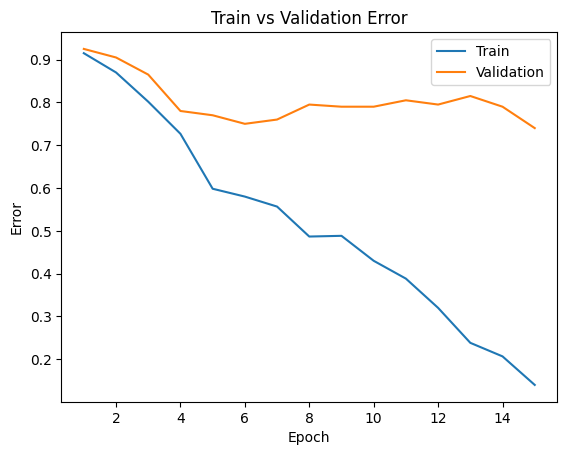

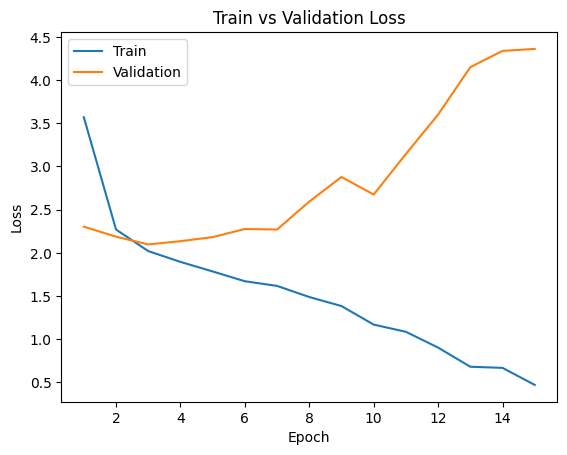

In [15]:

torch.manual_seed(0)
net = BaselineModel()
train_net(net, "baseline_model", learning_rate=0.01, num_epochs=15)
plot_training_curve("baseline_model")

Done Loading Data


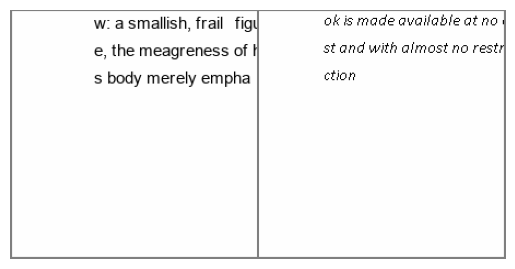

GroundTruth:  arial calibrii
Predicted:  bahnschrift calibrii


In [31]:


def visualize_output(num_images, dataset_path, model_path):

    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(dataset_path, batch_size=num_images)
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Print images
    img = torchvision.utils.make_grid(images, nrow=num_images)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    
    plt.show()
    
    # Print labels
    print('Ground Truth: ', ' '.join(f'{classes[np.argmax(labels[j], axis=0)]:5s}' for j in range(num_images)))

    # Load the model and print the predicted labels
    net = BaselineModel()
    net.load_state_dict(torch.load(model_path))
    outputs = net(images)
    outputs = np.argmax(outputs.detach().numpy(), axis=1)
    print('Predicted: ', ' '.join(f'{classes[outputs[j]]:5s}' for j in range(num_images)))

visualize_output(10, FONT_DATASET_PATH, "./baseline_model/best_baseline_model")